In [1]:
# Imports

# Be able to load python scripts
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

# Drawing and plotting
import matplotlib.pyplot as plt

# Draw the merged result
from PIL import Image, ImageDraw
Image.MAX_IMAGE_PIXELS = None

# Load results csv
import pandas as pd
import numpy as np

# Load summary.json
import json

# Load to determine max-size
import openslide as os

# NMS Prerequisites
import xml.etree.ElementTree as ET
from shapely.geometry.point import Point
from shapely.geometry.polygon import Polygon

# Import paths from config file
from src.config import SLIDE_DIR, RESULT_DIR, ANNOT_DIR

In [2]:
# Configurables
#EXPERIMENT_ID = 'TEST-TF2-VGG16-c6e5-4eb1-bf66-88b03210d7a3'
#EXPERIMENT_ID = 'BIG-TILE-0253-43ac-acbc-bbf75ff6a58f'
EXPERIMENT_ID = 'VGG16-TF2-DATASET-e95b-4e8f-aeea-b87904166a69'     # the 99.8% model
#EXPERIMENT_ID = 'VGG16-TF2-MINBG-FULLTRAIN-84ce-49b2-9c80-e888431382cf'
TEST_SLIDE_NAME = 'TP-2019_6785-13-1'
MODE = 'a'
LEVEL = 0
CENTER_SIZE = int(256 // (2**(LEVEL-1)))

In [3]:
def open_summary(experiment_id, verbose=0):
    # Load the experiment summary log
    with (RESULT_DIR / experiment_id / 'summary.json').open('r') as f_summary:
        d_summary = json.load(f_summary)

    # Retrieve path to result file, and determine offset
    s_level = d_summary['params']['data']['meta']['level']
    tile_size = d_summary['params']['data']['meta']['tile_size'] // (2**(LEVEL - s_level))
    offset = int((tile_size - CENTER_SIZE) // 2)
    if verbose > 0:
        print(f'Tile size: {tile_size}')
        print(f'Center size: {CENTER_SIZE}')
        print(f'Offset @L{LEVEL}: {offset}')
    return d_summary, offset
        
def get_heatmaps_for_experiment(experiment_id, verbose=0):
    d_summary, offset = open_summary(experiment_id, verbose)
    
    for slide_name in [slide_name for slide_name in d_summary['test']['summary']]:
        print(f'== SLIDE: {slide_name} ==')
        yield slide_name, offset, get_heatmap_for_slide(d_summary, slide_name, offset, verbose)

def get_heatmap_for_slide(d_summary, slide_name, offset, verbose=0):
    # Load the result pandas file
    fp_result = d_summary['test']['summary'][slide_name]['results']
    s_level = d_summary['params']['data']['meta']['level']
    df_result = pd.read_csv(fp_result, sep=';', index_col=0)

    # Determine the size of the slide
    os_slide = os.open_slide(str((SLIDE_DIR / slide_name).with_suffix('.mrxs').resolve()))
    dimensions = os_slide.level_dimensions[LEVEL]
    scale_factor = 2**LEVEL
    os_slide.close()

    # Prepare the canvas
    if MODE == 'a':
        result_intensity = np.zeros(tuple(reversed(dimensions)), dtype='float32')
    elif MODE == 'g':
        result_intensity = np.ones(tuple(reversed(dimensions)), dtype='float32')    
    result_counts = np.zeros(tuple(reversed(dimensions)), dtype='uint8')
    if verbose > 0:
        print('Intensity matrix size: {}'.format(result_intensity.shape))
        print('Count matrix size: {}'.format(result_counts.shape))

    # Draw the heatmap
    for index, row in df_result.iterrows(): 
        width  = slice((row.coord_x // scale_factor) + offset, (row.coord_x // scale_factor) + offset + CENTER_SIZE)
        height = slice((row.coord_y // scale_factor) + offset, (row.coord_y // scale_factor) + offset + CENTER_SIZE)
        if MODE == 'a':
            result_intensity[height, width] += row.predict
        elif MODE == 'g':
            result_intensity[height, width] *= row.predict
        result_counts[height, width] += 1

    if MODE == 'a':
        if verbose > 0:
            print('Arithmetic')
        np_merged_result = np.divide(result_intensity, result_counts, out=result_intensity, where=(result_counts > 0))
    elif MODE == 'g':
        if verbose > 0:
            print('Geometric')
        np_merged_result = np.power(result_intensity, np.divide(1, result_counts, out=result_intensity, where=result_counts > 0), where=result_counts > 0)

    del result_intensity
    del result_counts
    
    return np_merged_result, df_result

In [33]:
FIG_DIR = RESULT_DIR / EXPERIMENT_ID / 'test' / 'figs'
for slide_name, offset, (heatmap_np, df_result) in get_heatmaps_for_experiment(EXPERIMENT_ID):
    output_fn = str((FIG_DIR / (slide_name + '-vis')).with_suffix('.png'))
    Image.fromarray((heatmap_np * 255).astype('uint8')).save(output_fn)

== SLIDE: TP-2019_6785-06-0 ==
== SLIDE: TP-2019_6786-06-0 ==
== SLIDE: TP-2019_7207-06-1 ==
== SLIDE: TP-2019_6785-13-1 ==
== SLIDE: TP-2019_6786-08-0 ==
== SLIDE: TP-2019_6785-01-0 ==
== SLIDE: TP-2019_6786-09-0 ==
== SLIDE: TP-2019_6786-07-0 ==
== SLIDE: TP-2019_7207-11-0 ==
== SLIDE: TP-2019_7207-10-1 ==
== SLIDE: TP-2019_7488-03-1 ==
== SLIDE: TP-2019_2941-05-0 ==
== SLIDE: TP-2019_2623-06-0 ==
== SLIDE: TP-2019_7333-03-1 ==
== SLIDE: TP-2019_6785-14-1 ==
== SLIDE: TP-2019_7333-01-1 ==
== SLIDE: TP-2019_6786-01-1 ==
== SLIDE: TP-2019_6785-09-0 ==
== SLIDE: TP-2019_7207-08-0 ==
== SLIDE: TP-2019_7488-04-1 ==
== SLIDE: TP-2019_7207-04-1 ==
== SLIDE: TP-2019_7207-13-1 ==
== SLIDE: TP-2019_7207-02-0 ==
== SLIDE: TP-2019_7362-08-0 ==
== SLIDE: TP-2019_6887-04-0 ==
== SLIDE: TP-2019_7333-04-1 ==
== SLIDE: TP-2019_7333-07-0 ==
== SLIDE: TP-2019_6887-02-0 ==
== SLIDE: TP-2019_2623-09-0 ==
== SLIDE: TP-2019_7362-06-1 ==
== SLIDE: TP-2019_2623-12-1 ==
== SLIDE: TP-2019_6887-06-0 ==
== SLIDE

# NON-MAXIMUM SUPPRESSION

In [4]:
def load_annotation_polygons(slide_name):
    if slide_name[-1] == '0':
        return []
    
    fp_annotation = ((ANNOT_DIR / slide_name).with_suffix('.xml')).resolve()

    # Load polygon vertices
    include_keywords = ['Carcinoma', 'metastases']
    exclude_keywords = []
    all_keywords = include_keywords + exclude_keywords
    include_polygons = []
    exclude_polygons = []

    root = ET.parse(fp_annotation).getroot()
    for anno_tag in root.findall('Annotations/Annotation'):
        polygon = []

        keyword = anno_tag.get('PartOfGroup')

        if keyword in all_keywords:
            for coord in anno_tag.findall('Coordinates/Coordinate'):
                polygon.append((float(coord.get('X')) / (2**LEVEL),
                                float(coord.get('Y')) / (2**LEVEL)))

        if keyword in include_keywords:
            include_polygons.append(polygon)
        elif keyword in exclude_keywords:
            exclude_polygons.append(polygon)
    return include_polygons

### NMS from merged image

In [ ]:
def nms_from_merged_image():
    # Hyperparameters
    NMS_THRESHOLD = 0.99
    NMS_RADIUS = 256 # in pixels

    # Helper structures to count metrics
    NMS_POLYGONS = [Polygon(polygon) for polygon in include_polygons]
    NMS_FOUND = np.zeros_like(NMS_POLYGONS, dtype='bool')

    # NMS Metrics
    NMS_TP = 0
    NMS_FP = 0

    # Extract max tile
    coord_y, coord_x = np.unravel_index(np.argmax(np_merged_result), np_merged_result.shape)
    print(f'Point ({coord_x}, {coord_y}) with prediction of {np_merged_result[coord_y, coord_x]}')

    # Verify above threshold
    is_valid = np_merged_result[coord_y, coord_x] > NMS_THRESHOLD
    print(f'Above threshold: {is_valid}')

    while is_valid:

        start_x = coord_x - NMS_RADIUS
        end_x   = coord_x + NMS_RADIUS + 1
        start_y = coord_y - NMS_RADIUS
        end_y   = coord_y + NMS_RADIUS + 1

        np_merged_result[start_y:end_y, start_x:end_x] = 0

        nms_predict_polygon = Polygon([(start_x, start_y), (end_x, start_y), (end_x, end_y), (start_x, end_y)])
        nms_intersects = np.array([nms_polygon.intersects(nms_predict_polygon) for nms_polygon in NMS_POLYGONS])

        if np.any(nms_intersects):
            NMS_TP += np.count_nonzero(NMS_FOUND[np.nonzero(nms_intersects)[0]] == 0)
            NMS_FOUND[np.nonzero(nms_intersects)] = True
        else:
            NMS_FP += 1

        # Extract max tile
        coord_y, coord_x = np.unravel_index(np.argmax(np_merged_result), np_merged_result.shape)
        print(f'Point ({coord_x}, {coord_y}) with prediction of {np_merged_result[coord_y, coord_x]}')

        # Verify above threshold
        is_valid = np_merged_result[coord_y, coord_x] > NMS_THRESHOLD
        print(f'Above threshold: {is_valid}')

### NMS from Image presampled

In [ ]:
def nms_from_presampled_image():
    # Hyperparameters
    NMS_THRESHOLD = 0.50
    NMS_RADIUS = 256 # in pixels

    # Helper structures to count metrics
    NMS_POLYGONS = [Polygon(polygon) for polygon in include_polygons]
    NMS_FOUND = np.zeros_like(NMS_POLYGONS, dtype='bool')

    # NMS Metrics
    NMS_TP = 0
    NMS_FP = 0

    # Prepare iterable for slide
    db_res = np.where(np_merged_result > NMS_THRESHOLD)
    db_vals = np_merged_result[db_res]

    while len(db_vals) > 0:
        print(f'Remaining points: {len(db_vals):,}\r', end='')

        # Extract max tile
        max_idx = np.argmax(db_vals)
        coord_y, coord_x = db_res[0][max_idx], db_res[1][max_idx]
        #print(f'Point ({coord_x}, {coord_y}) with prediction of {db_vals[max_idx]}')

        start_x = coord_x - NMS_RADIUS
        end_x   = coord_x + NMS_RADIUS + 1
        start_y = coord_y - NMS_RADIUS
        end_y   = coord_y + NMS_RADIUS + 1

        np_merged_result[start_y:end_y, start_x:end_x] = 0

        nms_predict_polygon = Polygon([(start_x, start_y), (end_x, start_y), (end_x, end_y), (start_x, end_y)])
        nms_intersects = np.array([nms_polygon.intersects(nms_predict_polygon) for nms_polygon in NMS_POLYGONS])

        if np.any(nms_intersects):
            NMS_TP += np.count_nonzero(NMS_FOUND[np.nonzero(nms_intersects)[0]] == 0)
            NMS_FOUND[np.nonzero(nms_intersects)] = True
        else:
            NMS_FP += 1

        # Renew values
        db_vals = np_merged_result[db_res]
        db_ind = np.argwhere(db_vals > NMS_THRESHOLD).flatten()
        db_vals = db_vals[db_ind]
        db_res = (db_res[0][db_ind], db_res[1][db_ind])

### NMS from result dataframe

In [5]:
def nms_from_dataframe(df_result, np_merged_result, include_polygons, nms_threshold, nms_radius, neighborhood, offset, verbose=0):

    # Helper structures to count metrics
    NMS_POLYGONS = [Polygon(polygon) for polygon in include_polygons]
    NMS_FOUND = np.zeros_like(NMS_POLYGONS, dtype='bool')

    # NMS Points
    EXTRACTED_POINTS = []

    # Extract max tile
    max_idx = df_result['predict'].idxmax()
    max_row = df_result.iloc[max_idx]
    if verbose > 0:
        print(f'Point ({max_row.coord_x}, {max_row.coord_y}) with prediction of {max_row.predict}')

    # Verify above threshold
    is_valid = max_row.predict >= nms_threshold
    if verbose > 0:
        print(f'Above threshold: {is_valid}')

    while is_valid:
        # Extract coordinates
        coord_x = max_row.coord_x // (2**LEVEL)
        coord_y = max_row.coord_y // (2**LEVEL)
        if verbose > 1:
            print(f'Point({coord_x},{coord_y})')

        # Verify it was not suppressed
        is_suppressed = np_merged_result[coord_y, coord_x] == 0
        if verbose > 1:
            print(f'Suppressed: {is_suppressed}')

        if not is_suppressed:

            if neighborhood == 'context':
                # Context radius
                start_x = (coord_x + offset) - (nms_radius     * CENTER_SIZE)
                end_x =   (coord_x + offset) + ((nms_radius+1) * CENTER_SIZE)
                start_y = (coord_y + offset) - (nms_radius     * CENTER_SIZE)
                end_y =   (coord_y + offset) + ((nms_radius+1) * CENTER_SIZE)
            elif neighborhood == 'google':
                # Possible Google context
                start_x = (coord_x + offset) - (nms_radius * CENTER_SIZE)
                end_x =   (coord_x + offset) + (nms_radius * CENTER_SIZE) + 1
                start_y = (coord_y + offset) - (nms_radius * CENTER_SIZE)
                end_y =   (coord_y + offset) + (nms_radius * CENTER_SIZE) + 1
            else:
                raise ValueError('Unknown neighborhood type.')

            np_merged_result[start_y:end_y, start_x:end_x] = 0

            test_polygon = Polygon([(start_x, start_y), (end_x, start_y), (end_x, end_y), (start_x, end_y)])
            nms_intersects = np.array([nms_polygon.intersects(test_polygon) for nms_polygon in NMS_POLYGONS])

            if np.any(nms_intersects):
                [EXTRACTED_POINTS.append((max_idx, max_row.predict, polygon_id)) for polygon_id in np.nonzero(nms_intersects)[0]]
                NMS_FOUND[np.nonzero(nms_intersects)] = True
            else:
                EXTRACTED_POINTS.append((max_idx, max_row.predict, -1))

        df_result.at[max_idx, 'predict'] = 0.0

        # Extract max tile
        max_idx = df_result['predict'].idxmax()
        max_row = df_result.iloc[max_idx]

        # Verify above threshold
        is_valid = max_row.predict >= nms_threshold
        if verbose > 1:
            print(f'Above threshold: {is_valid}')
    return EXTRACTED_POINTS, len(NMS_POLYGONS)

In [ ]:
json_summary, offset = open_summary(EXPERIMENT_ID)
np_merged_result, df_result = get_heatmap_for_slide(json_summary, 'TP-2019_7207-06-1', offset, 0)
nms_points, nms_polygons = nms_from_dataframe(df_result.copy(), np_merged_result.copy(), load_annotation_polygons('TP-2019_7207-06-1'), 0.5, 1, 'google', offset, 0)

# Create DataFrame with points and confidences
idx, conf, polygon_id = zip(*nms_points)
df_nms = pd.DataFrame({'idx':idx, 'conf': conf, 'polygon':polygon_id})

# Calculate values for each threshold
FROC_THRESHOLDS = [1.0, 0.999, 0.99, 0.9, 0.85, 0.80, 0.75]
for froc_threshold in FROC_THRESHOLDS:
    FP = df_nms[df_nms.conf >= froc_threshold].polygon.lt(0).sum()
    TP = np.sum(df_nms[df_nms.conf >= froc_threshold].polygon.unique() >= 0)
    print(f'@{froc_threshold:.2%}  TP: {TP}/{nms_polygons}  FP: {FP}  Recall: {TP/nms_polygons:.2%}')

In [6]:
ALL_DF_NMS = []

# Open experiment summary.json
json_summary, offset = open_summary(EXPERIMENT_ID)
for slide_name in json_summary['test']['summary']:
    # Open predictions for each slide and get all NMS regions
    np_merged_result, df_result = get_heatmap_for_slide(json_summary, slide_name, offset, 0)
    nms_points, nms_polygons = nms_from_dataframe(df_result.copy(), np_merged_result.copy(), load_annotation_polygons(slide_name), 0.50, 1, 'google', offset, 0)
    
    # Create DataFrame with points and confidences
    if len(nms_points) > 0:
        idx, conf, polygon_id = zip(*nms_points)
    else:
        idx = []
        conf = []
        polygon_id = []
    df_nms = pd.DataFrame({'idx':idx, 'conf': conf, 'polygon':polygon_id})

    ALL_DF_NMS.append((df_nms, nms_polygons))

In [ ]:
pos_filter = [slide_name[-1] == '1' for slide_name in list(json_summary['test']['summary'].keys())]

In [7]:
# Calculate values for each threshold
FROC_THRESHOLDS = np.arange(1.0, 0.50, -0.0005)
sens_l = []
avfp_l = []
for froc_threshold in FROC_THRESHOLDS:
    sTP = 0
    aTP = 0
    aFP = 0
    aTOTAL = 0
    for df_nms, num_polygons in np.array(ALL_DF_NMS):
        if len(df_nms) > 0:
            FP = df_nms[df_nms.conf >= froc_threshold].polygon.lt(0).sum()
            TP = np.sum(df_nms[df_nms.conf >= froc_threshold].polygon.unique() >= 0)
        else:
            FP = 0
            TP = 0
            
        if TP > 0:
            sTP += 1
        
        # Accumulate metrics
        aTP += TP
        aFP += FP
        aTOTAL += num_polygons
    #print(f'@{froc_threshold:.4f}  TP: {aTP}/{aTOTAL}  avg.FP: {aFP / len(ALL_DF_NMS):.2f}  Recall: {aTP/aTOTAL:.2%}  Slide: {sTP}/{sum(pos_filter)}')
    sens_l.append(aTP/aTOTAL)
    avfp_l.append(aFP/len(ALL_DF_NMS))

In [8]:
# Only keep those above 8 AVG FP
f = np.array(avfp_l) <= 8

In [9]:
# Calculate FROC Score
from sklearn.metrics import auc
auc(x=np.array(avfp_l)[f], y=np.array(sens_l)[f]) / 8

0.8201352048334807

In [71]:
from scipy.interpolate import interp1d
inter_f = interp1d(x=np.array(avfp_l)[f], y=np.array(sens_l)[f])
print(f'Sensitivity at 1/4FP: {inter_f(0.25):.2%}')
print(f'Sensitivity at 1/2FP: {inter_f(0.5):.2%}')
print(f'Sensitivity at 1FP: {inter_f(1):.2%}')
print(f'Sensitivity at 2FP: {inter_f(2):.2%}')
print(f'Sensitivity at 4FP: {inter_f(4):.2%}')
print(f'Sensitivity at 8FP: {inter_f(8):.2%}')

Sensitivity at 1/4FP: 49.30%
Sensitivity at 1/2FP: 59.86%
Sensitivity at 1FP: 73.04%
Sensitivity at 2FP: 80.95%
Sensitivity at 4FP: 87.18%
Sensitivity at 8FP: 91.21%


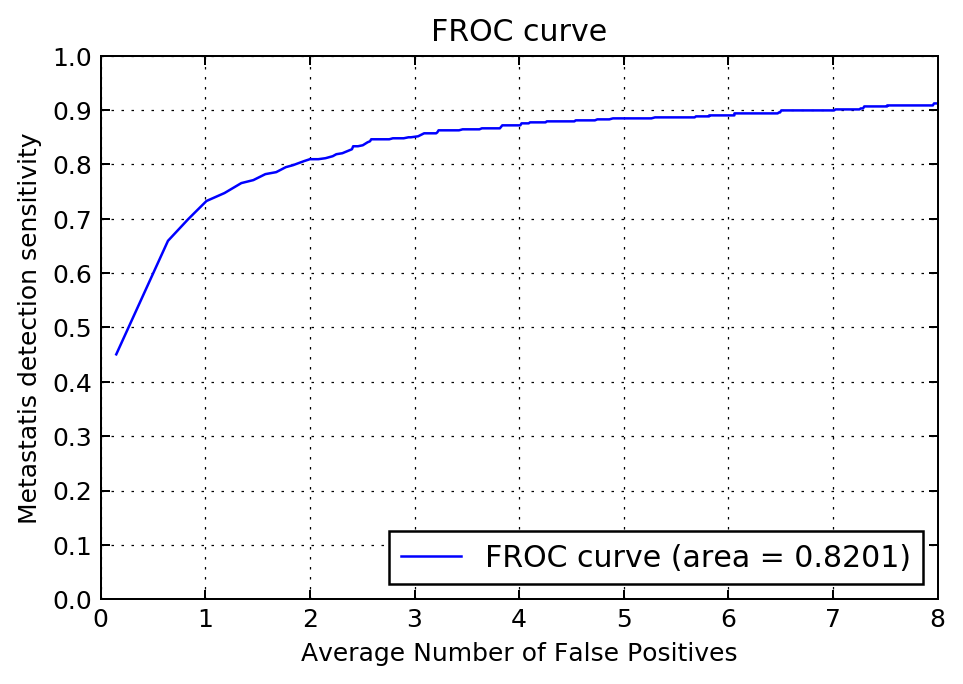

In [91]:
import matplotlib.pyplot as plt

label = f'FROC curve (area = {auc(x=np.array(avfp_l)[f], y=np.array(sens_l)[f]) / 8:.4})'

plt.figure(dpi=180)
ax = plt.gca()
ax.get_yaxis().set_tick_params(direction='in', right=True)
ax.get_xaxis().set_tick_params(direction='in', top=True)
plt.plot(np.array(avfp_l)[f], np.array(sens_l)[f], color='blue',
         lw=1, label=label)
plt.xlim([0, 8])
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.ylim([0.0, 1.0])
plt.xlabel('Average Number of False Positives')
plt.ylabel('Metastatis detection sensitivity')
plt.title('FROC curve')
plt.legend(loc="lower right", fontsize='large', fancybox=False, framealpha=1, edgecolor='black')
plt.grid(True, linestyle='--', color='black', lw=0.5, dashes=(2,6,2,6))
plt.show()

# CONNECTED COMPONENT FROC

In [11]:
from skimage.measure import label, regionprops
from skimage.morphology import binary_dilation, binary_erosion
from skimage.draw import polygon
# Get centroid points for found tumors
from scipy import ndimage
from rasterio.features import shapes

Intensity matrix size: (3465, 1643)
Count matrix size: (3465, 1643)
Arithmetic


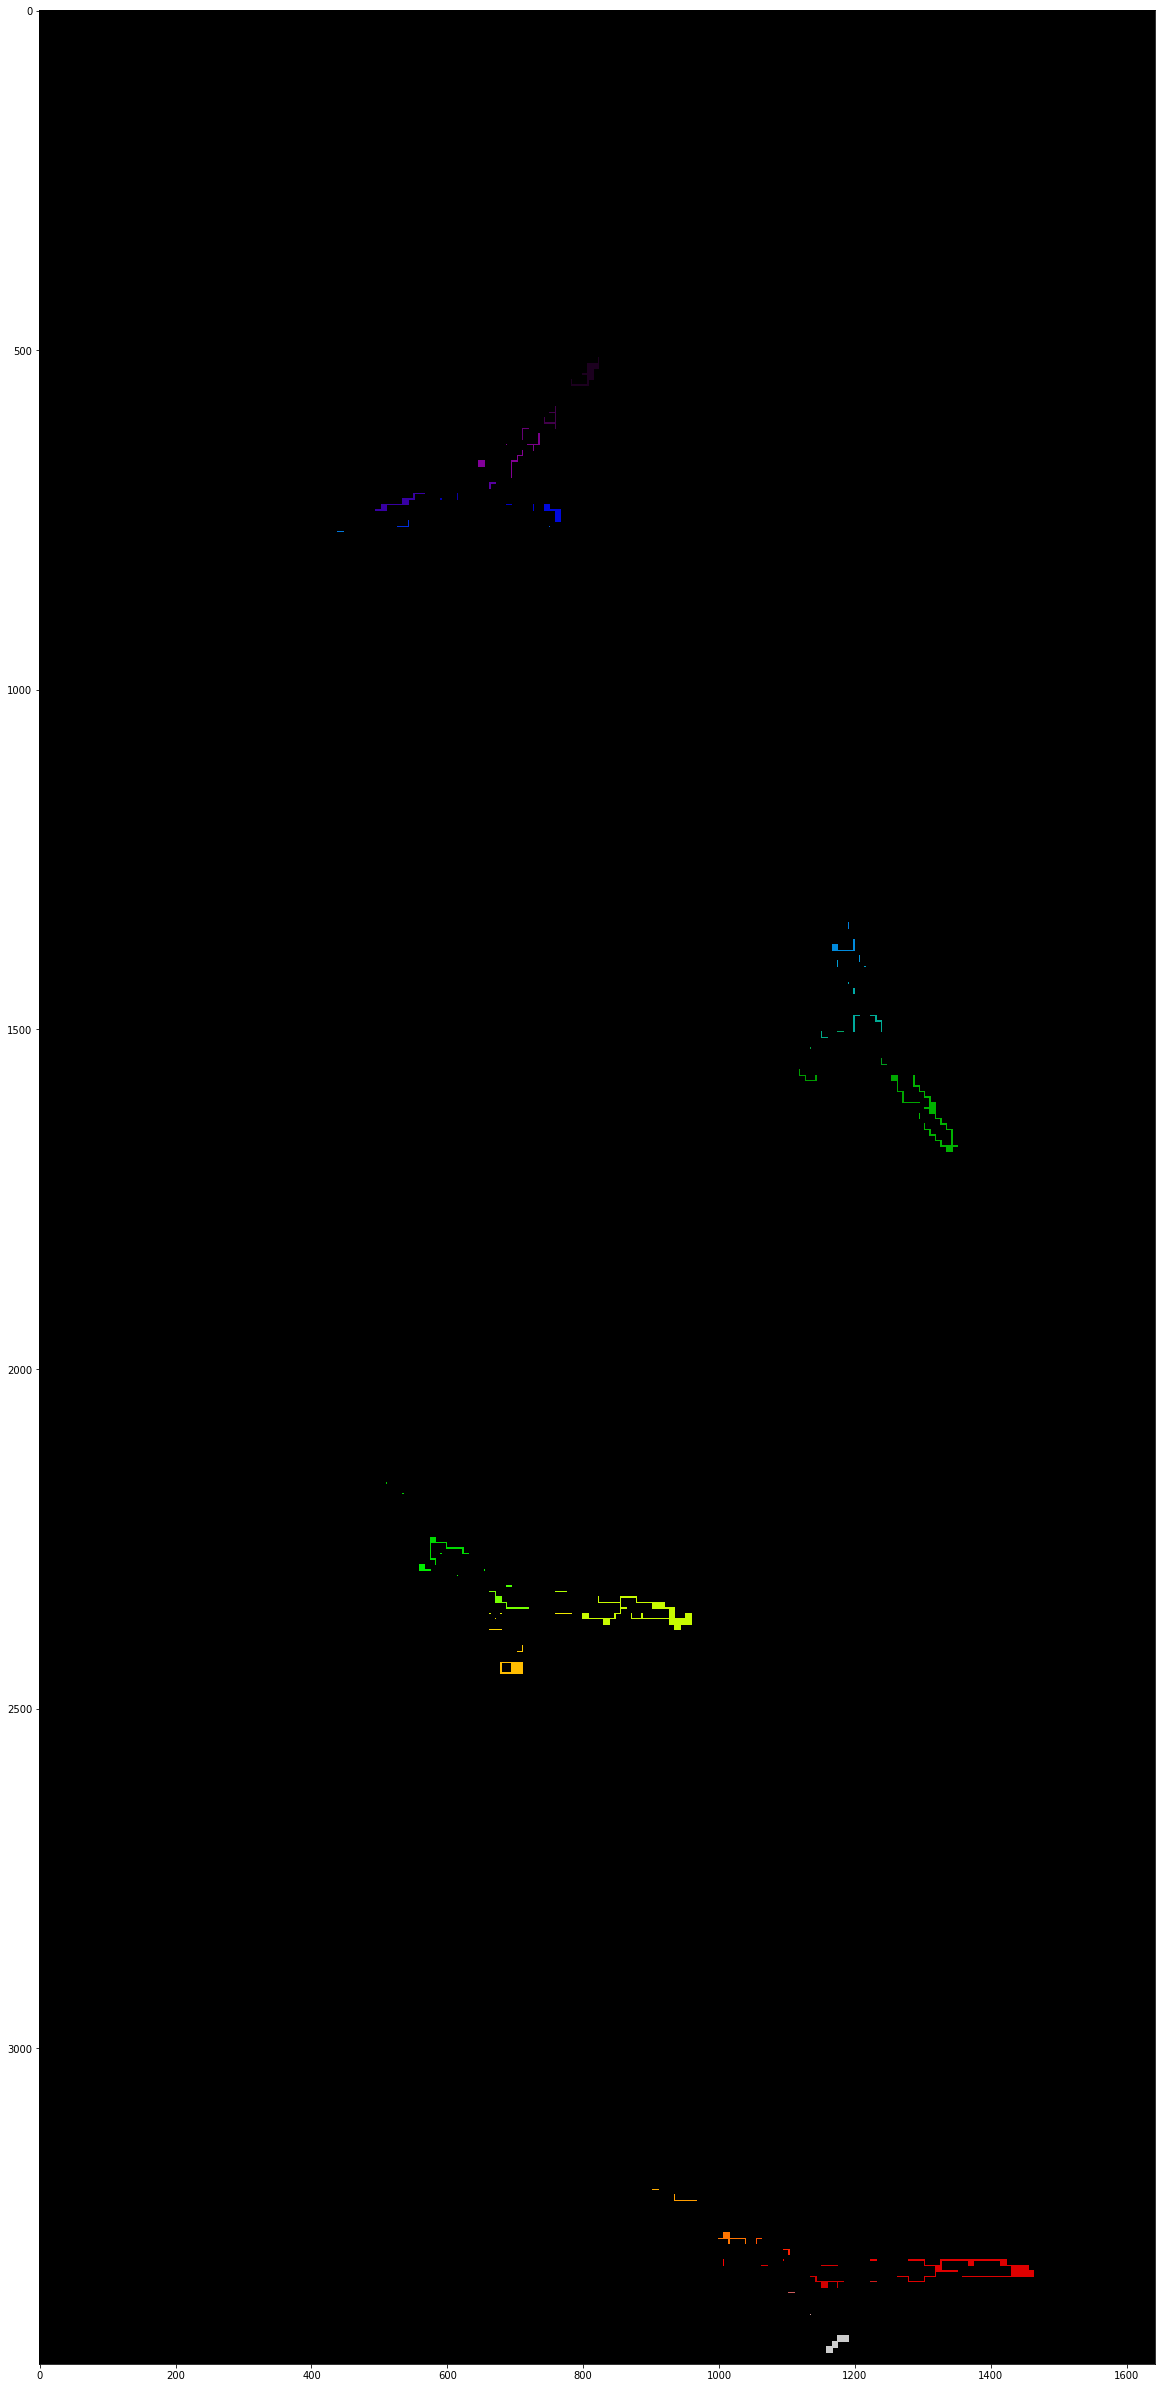

In [26]:
SLIDE_NAME = 'TP-2019_6785-13-1'

# Load the heatmap
json_summary, offset = open_summary(EXPERIMENT_ID)
merged_result, df_result = get_heatmap_for_slide(json_summary, SLIDE_NAME, offset, verbose=1)

# Threshold the heatmap
CC_THRESHOLD = 0.40
thresholded_result = np.where(merged_result > CC_THRESHOLD, 255, 0)

# Erode predictions
thresholded_result = binary_erosion(thresholded_result, selem=np.ones((7,7)))

# Label connected components
labels = label(thresholded_result, background=0, connectivity=2)
props = regionprops(labels, intensity_image=merged_result)

# Display connected components
plt.figure(figsize=(20,60))
plt.imshow(labels, cmap='nipy_spectral')

# Get centroid points for found tumors
centroids = [(Point(int(prop.weighted_centroid[1]), int(prop.weighted_centroid[0])), prop.mean_intensity) for prop in props]  # / 32 for coords
centroids = sorted(centroids, key=lambda x: x[1], reverse=True)

# Make polygons have integer values to work with numpy
int_np_polygons = [np.array(polygon_).astype('int') for polygon_ in load_annotation_polygons(SLIDE_NAME)]
int_polygons = [Polygon(polygon_) for polygon_ in int_np_polygons]

#polygons = [Polygon(polygon_) for polygon_ in load_annotation_polygons(SLIDE_NAME)]

In [ ]:
# Old way of doing it without dilation
DISPLAY = False
if DISPLAY:
    # Initialize counters
    CC_TP = 0
    CC_FP = 0
    hits = [False] * len(centroids)


    for idx,cc in enumerate(centroids):
        # Filter by mean intensity for FROC
        if cc[1] < 0.95:
            continue

        # Check if centroid lies within an annotated polygon
        # and update counters accordingly
        for polygon_ in int_polygons:
            if polygon_.contains(cc[0]):
                if hits[idx] == False:
                    CC_TP += 1
                    hits[idx] = True
                break
        else:
            CC_FP += 1

    print(f'{sum(hits)}/{len(hits)}')
    print(f'TP: {CC_TP}  FP: {CC_FP}')

In [ ]:
# Display the outlines of polygons and centroids
if DISPLAY:
    plt.figure(figsize=(20,60))
    for polygon_ in int_polygons:
        plt.plot(*polygon_.exterior.xy, c='g')
    for cc in tmp:
        plt.plot(*cc[0].xy, 'ro')

In [27]:
# Draw binary image using the integer polygons
res = np.zeros_like(merged_result).astype(bool)
for int_polygon in int_polygons:
    coords = polygon(int_polygon.exterior.xy[1], int_polygon.exterior.xy[0])
    res[coords] = True
    
# Binary dilation
ORIG_DILATION = 21
dil_res = binary_dilation(res, selem=np.ones((1,1)))

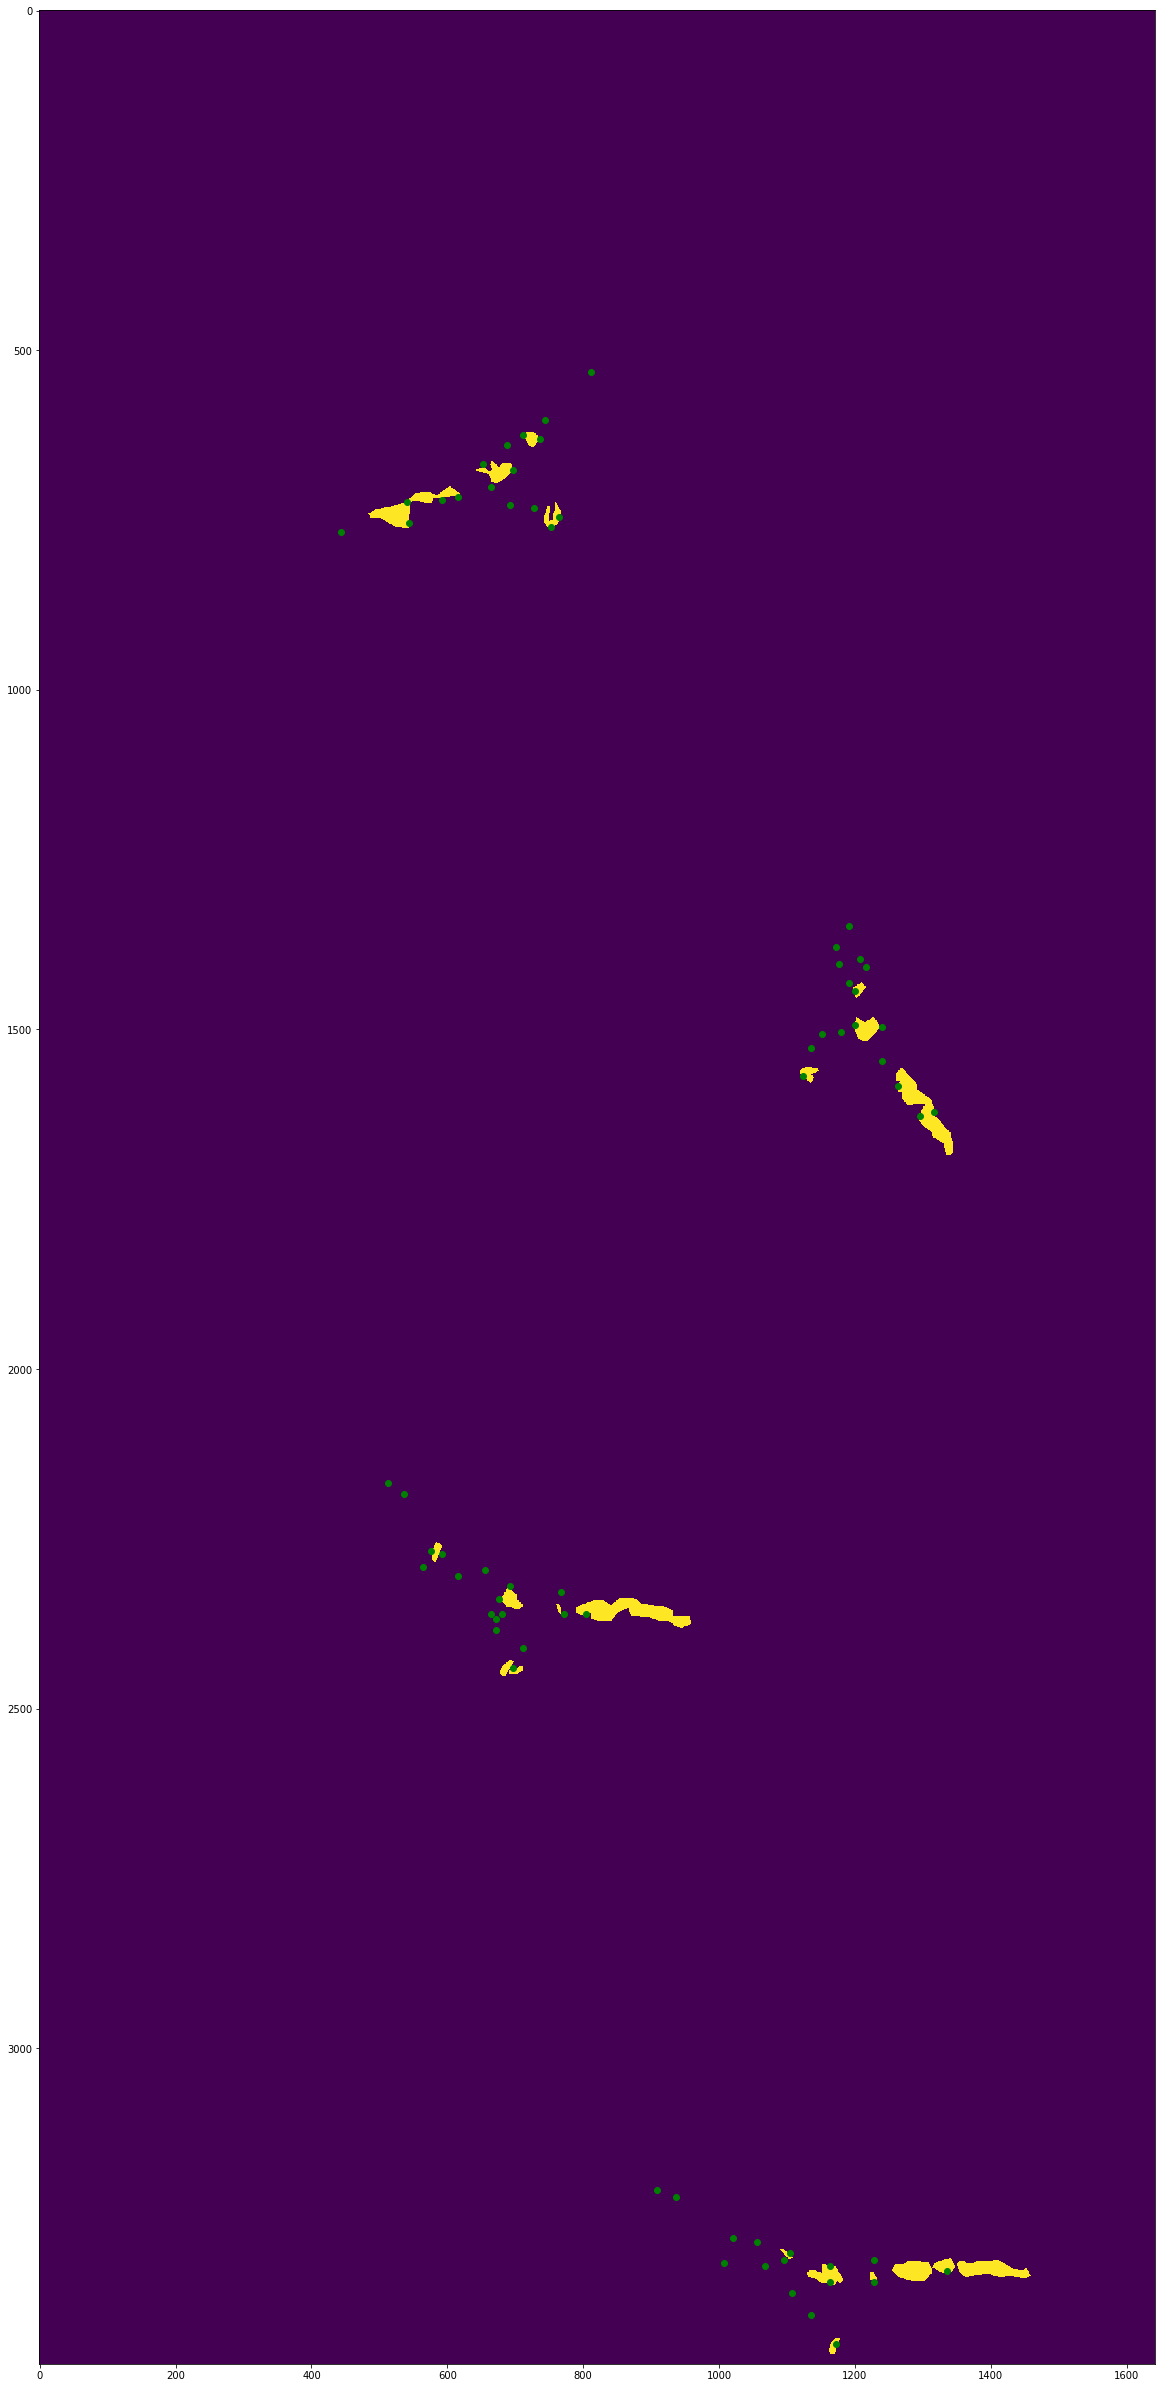

In [28]:
old_points = []
new_points = []
for prop in props:
    # Draw polygon
    db_canvas = np.zeros_like(labels, dtype='uint8')
    db_x, db_y = np.transpose(prop.coords)
    db_canvas[db_x, db_y] = 255

    polygons = [vec[0]['coordinates'][0] for vec in shapes(db_canvas, mask=db_canvas)]

    for polygon_ in polygons:
        old_points.append(Polygon(polygon_).centroid.xy)
        new_points.append(Polygon(polygon_).representative_point().xy)
        
plt.figure(figsize=(20,60))
plt.imshow(dil_res)
#for point in old_points:
#    plt.plot(*point, 'ro')
for point in new_points:
    plt.plot(*point, 'go')

Found: 12 out of 12 (100.00%)


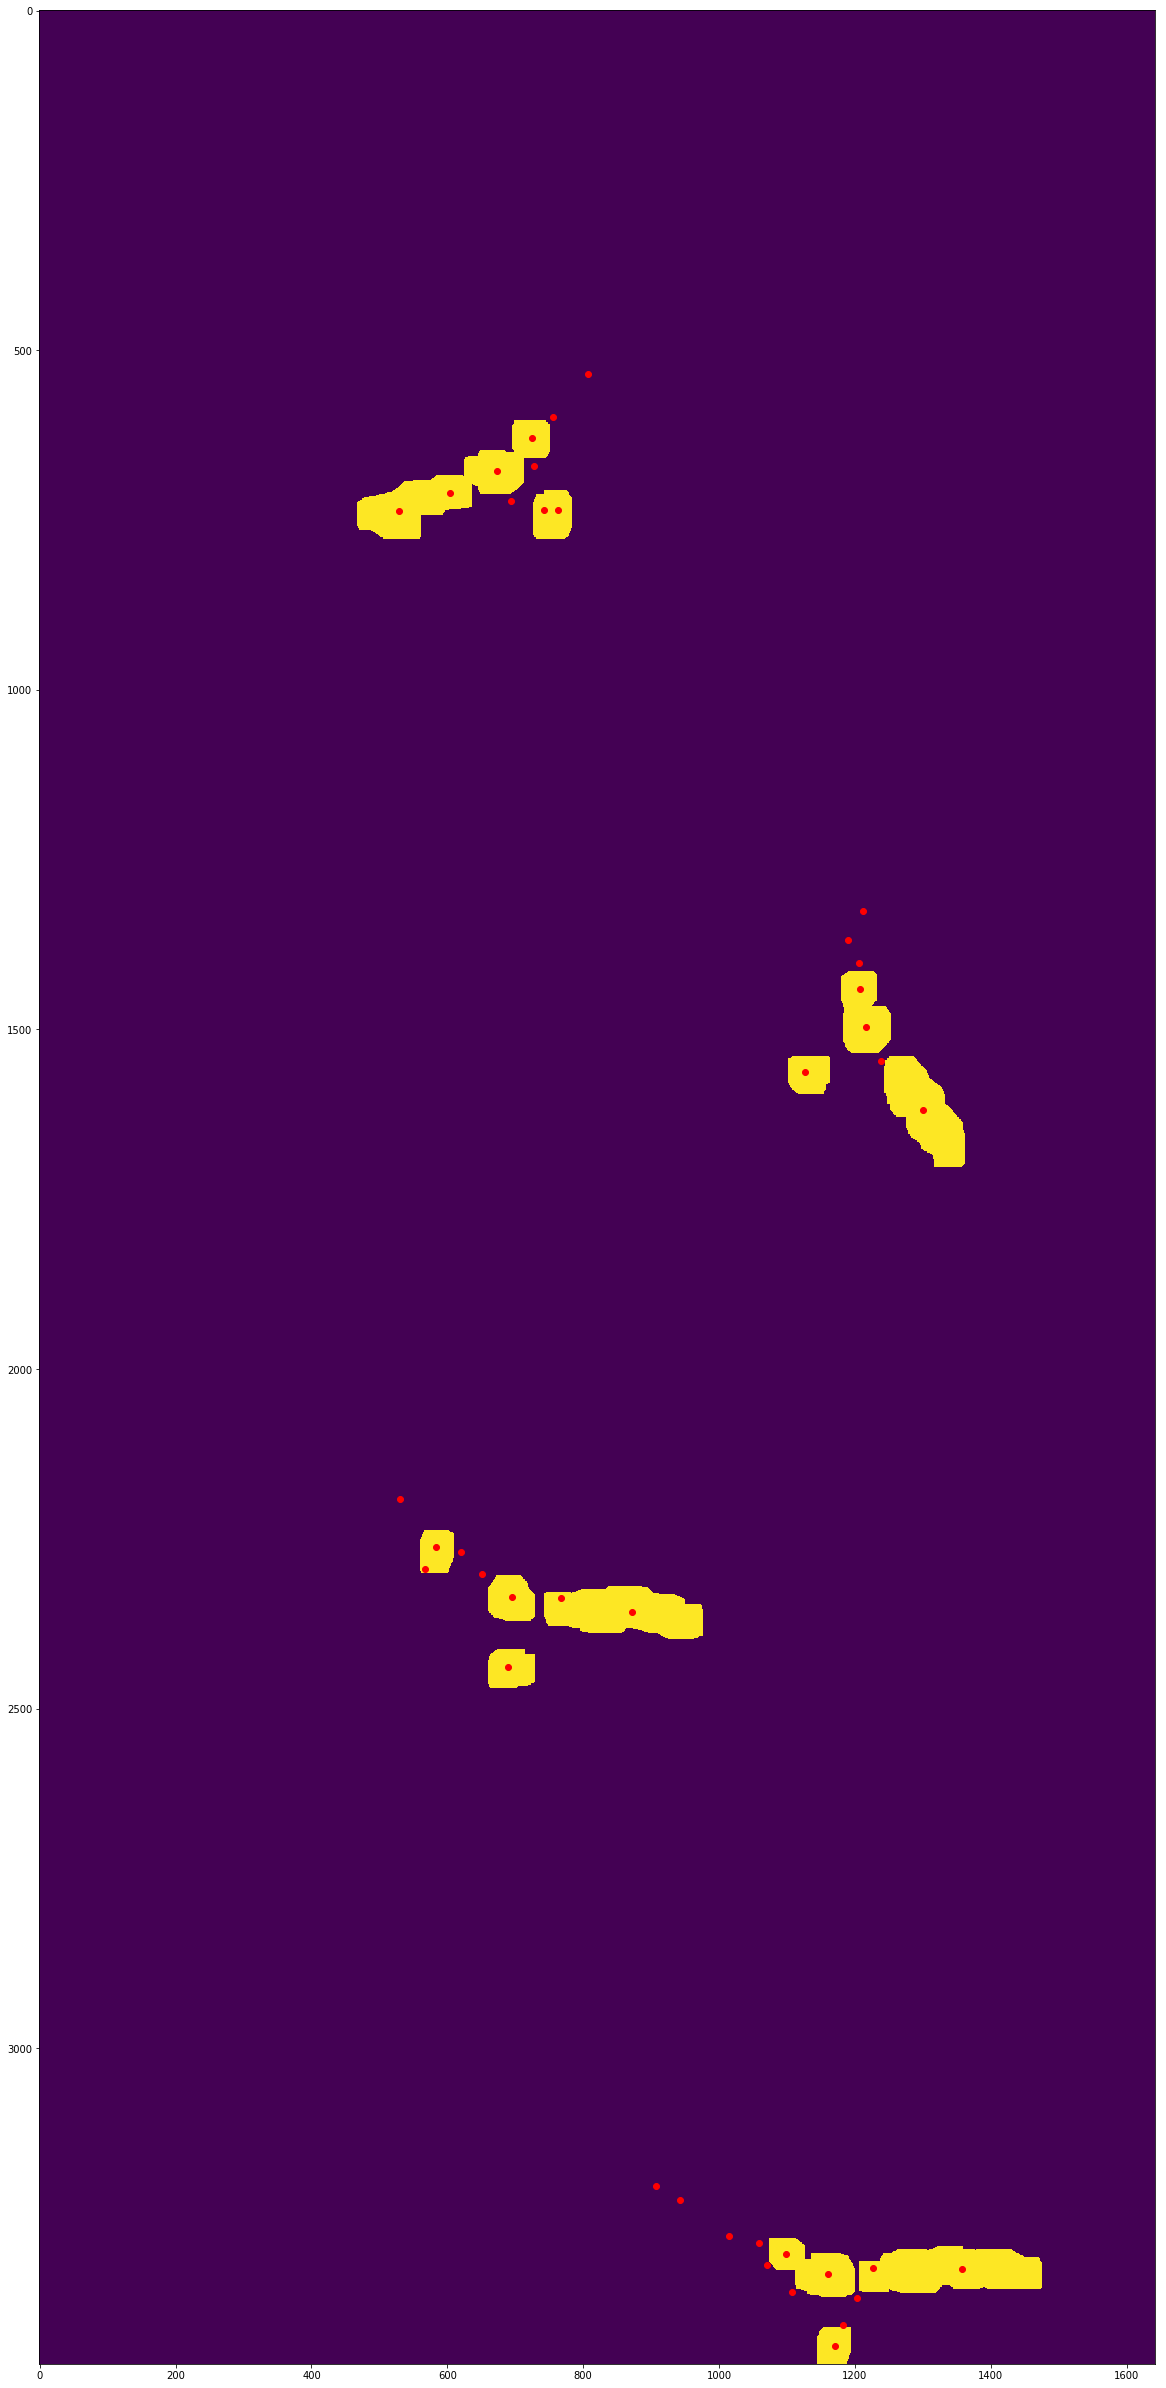

In [22]:
# Get labels for annotated polygons
true_labels, true_num_labels = label(dil_res, background=0, connectivity=2, return_num=True)

# Calculate hit ratio
int_centroids = [(int(prop.centroid[0]), int(prop.centroid[1])) for prop in props]
int_hits_polygons = [true_labels[int_centroid] for int_centroid in int_centroids]
num_dilated_hits = np.sum(np.unique(int_hits_polygons) > 0)
print(f'Found: {num_dilated_hits} out of {true_num_labels} ({num_dilated_hits / true_num_labels:.2%})')

# Draw dilated annotated polygons with center point hits
plt.figure(figsize=(20,60))
plt.imshow(dil_res)
for cc in centroids:
    plt.plot(*cc[0].xy, 'ro')

In [ ]:
FIG_DIR = Path('/mnt/data/home/matejg/centroids/old/')
for slide_name, offset, (merged_result, df_result) in get_heatmaps_for_experiment(EXPERIMENT_ID):
    output_fn = str((FIG_DIR / (slide_name + '-cen')).with_suffix('.png'))
    #Image.fromarray(heatmap_np.astype('uint8')).save(output_fn)

    # Threshold the heatmap
    CC_THRESHOLD = 0.90
    thresholded_result = np.where(merged_result > CC_THRESHOLD, 255, 0)

    # Erode predictions
    thresholded_result = binary_erosion(thresholded_result, selem=np.ones((1,1)))

    # Label connected components
    labels = label(thresholded_result, background=0, connectivity=2)
    props = regionprops(labels, intensity_image=merged_result)

    # Make polygons have integer values to work with numpy
    int_np_polygons = [np.array(polygon_).astype('int') for polygon_ in load_annotation_polygons(slide_name)]
    int_polygons = [Polygon(polygon_) for polygon_ in int_np_polygons]

    # Draw binary image using the integer polygons
    res = np.zeros_like(merged_result).astype(bool)
    for int_polygon in int_polygons:
        coords = polygon(int_polygon.exterior.xy[1], int_polygon.exterior.xy[0])
        res[coords] = True

    # Binary dilation
    dil_res = binary_dilation(res, selem=np.ones((21,21)))
    
    # Calculate new shapely.polygon (HEAVILY INEFFICIENT!)
    # May produce more polygons than were originally present
    new_points = []
    old_points = []
    for prop in props:
        # Draw polygon
        db_canvas = np.zeros_like(labels, dtype='uint8')
        db_x, db_y = np.transpose(prop.coords)
        db_canvas[db_x, db_y] = 255
    
        # Get centroids
        polygons = [vec[0]['coordinates'][0] for vec in shapes(db_canvas, mask=db_canvas)]
        for polygon_ in polygons:
            old_points.append(Polygon(polygon_).centroid.xy)
            new_points.append(Polygon(polygon_).representative_point().xy)

    plt.figure(figsize=(20,60))
    plt.imshow(dil_res)
    for point in old_points:
        plt.plot(*point, 'ro')
    plt.savefig(output_fn, bbox_inches='tight')
    plt.close()